# Part 1: Single subject classification (subject 1)
### Import required libraries

In [1]:
# Import Required Libraries
import os
import zipfile
import pandas as pd
import seaborn as sns
import scipy.io as sio
from scipy.ndimage import convolve1d
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.feature_selection import SelectKBest, SelectFromModel, mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

In [2]:
from functions import *

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

### Load and extract data

In [3]:
# Define the base path to the zip files and the extraction directory
base_zip_path = '../data/'
extraction_dir = '../data/'

# Loop through all 27 subjects
for subject_num in range(1, 28):
    zip_file_path = os.path.join(base_zip_path, f's{subject_num}.zip')
    
    # Extract the zip file
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extraction_dir)
    
    # Define the paths to the .mat files
    mat_file_path_e1 = os.path.join(extraction_dir, f'S{subject_num}_A1_E1.mat')
    mat_file_path_e2 = os.path.join(extraction_dir, f'S{subject_num}_A1_E2.mat')
    mat_file_path_e3 = os.path.join(extraction_dir, f'S{subject_num}_A1_E3.mat')
    
    # Delete the S[subject number]_A1_E2.mat and S[subject number]_A1_E3.mat files
    if os.path.exists(mat_file_path_e2):
        os.remove(mat_file_path_e2)
    if os.path.exists(mat_file_path_e3):
        os.remove(mat_file_path_e3)
    
# Now, specifically work on S2_A1_E1.mat
subject_num = 2
mat_file_path_e1 = os.path.join(extraction_dir, f'S{subject_num}_A1_E1.mat')

# Load the .mat file using scipy.io.loadmat
mat_data = sio.loadmat(mat_file_path_e1)

# Print the keys of the loaded .mat file to see available variables
print(mat_data.keys())

# Extract the data and labels
emg = mat_data['emg']
stimulus = mat_data['stimulus']
repetition = mat_data['repetition']

# Print the shape of the data and labels
print(f"Subject {subject_num} - EMG shape:", emg.shape)
print(f"Subject {subject_num} - Labels shape:", stimulus.shape)
print(f"Subject {subject_num} - Repetitions shape:", repetition.shape)

dict_keys(['__header__', '__version__', '__globals__', 'subject', 'exercise', 'stimulus', 'emg', 'glove', 'restimulus', 'repetition', 'rerepetition'])
Subject 2 - EMG shape: (100686, 10)
Subject 2 - Labels shape: (100686, 1)
Subject 2 - Repetitions shape: (100686, 1)


### Visualize raw EMG data

/var/folders/q_/xhgs30s966s2xsy_tl8w2k680000gp/T/ipykernel_62026/1329682388.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', emg.shape[1]) # Define a color map


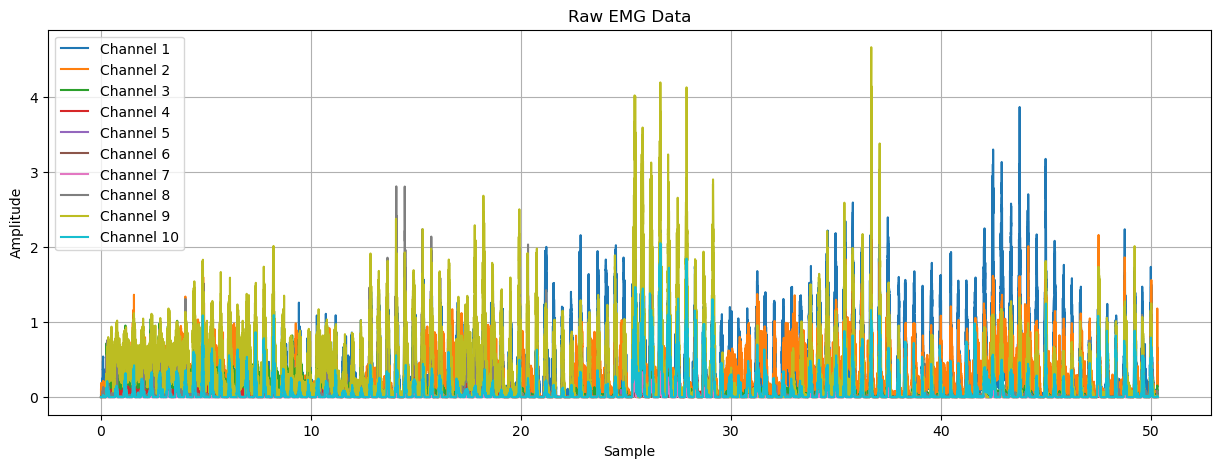

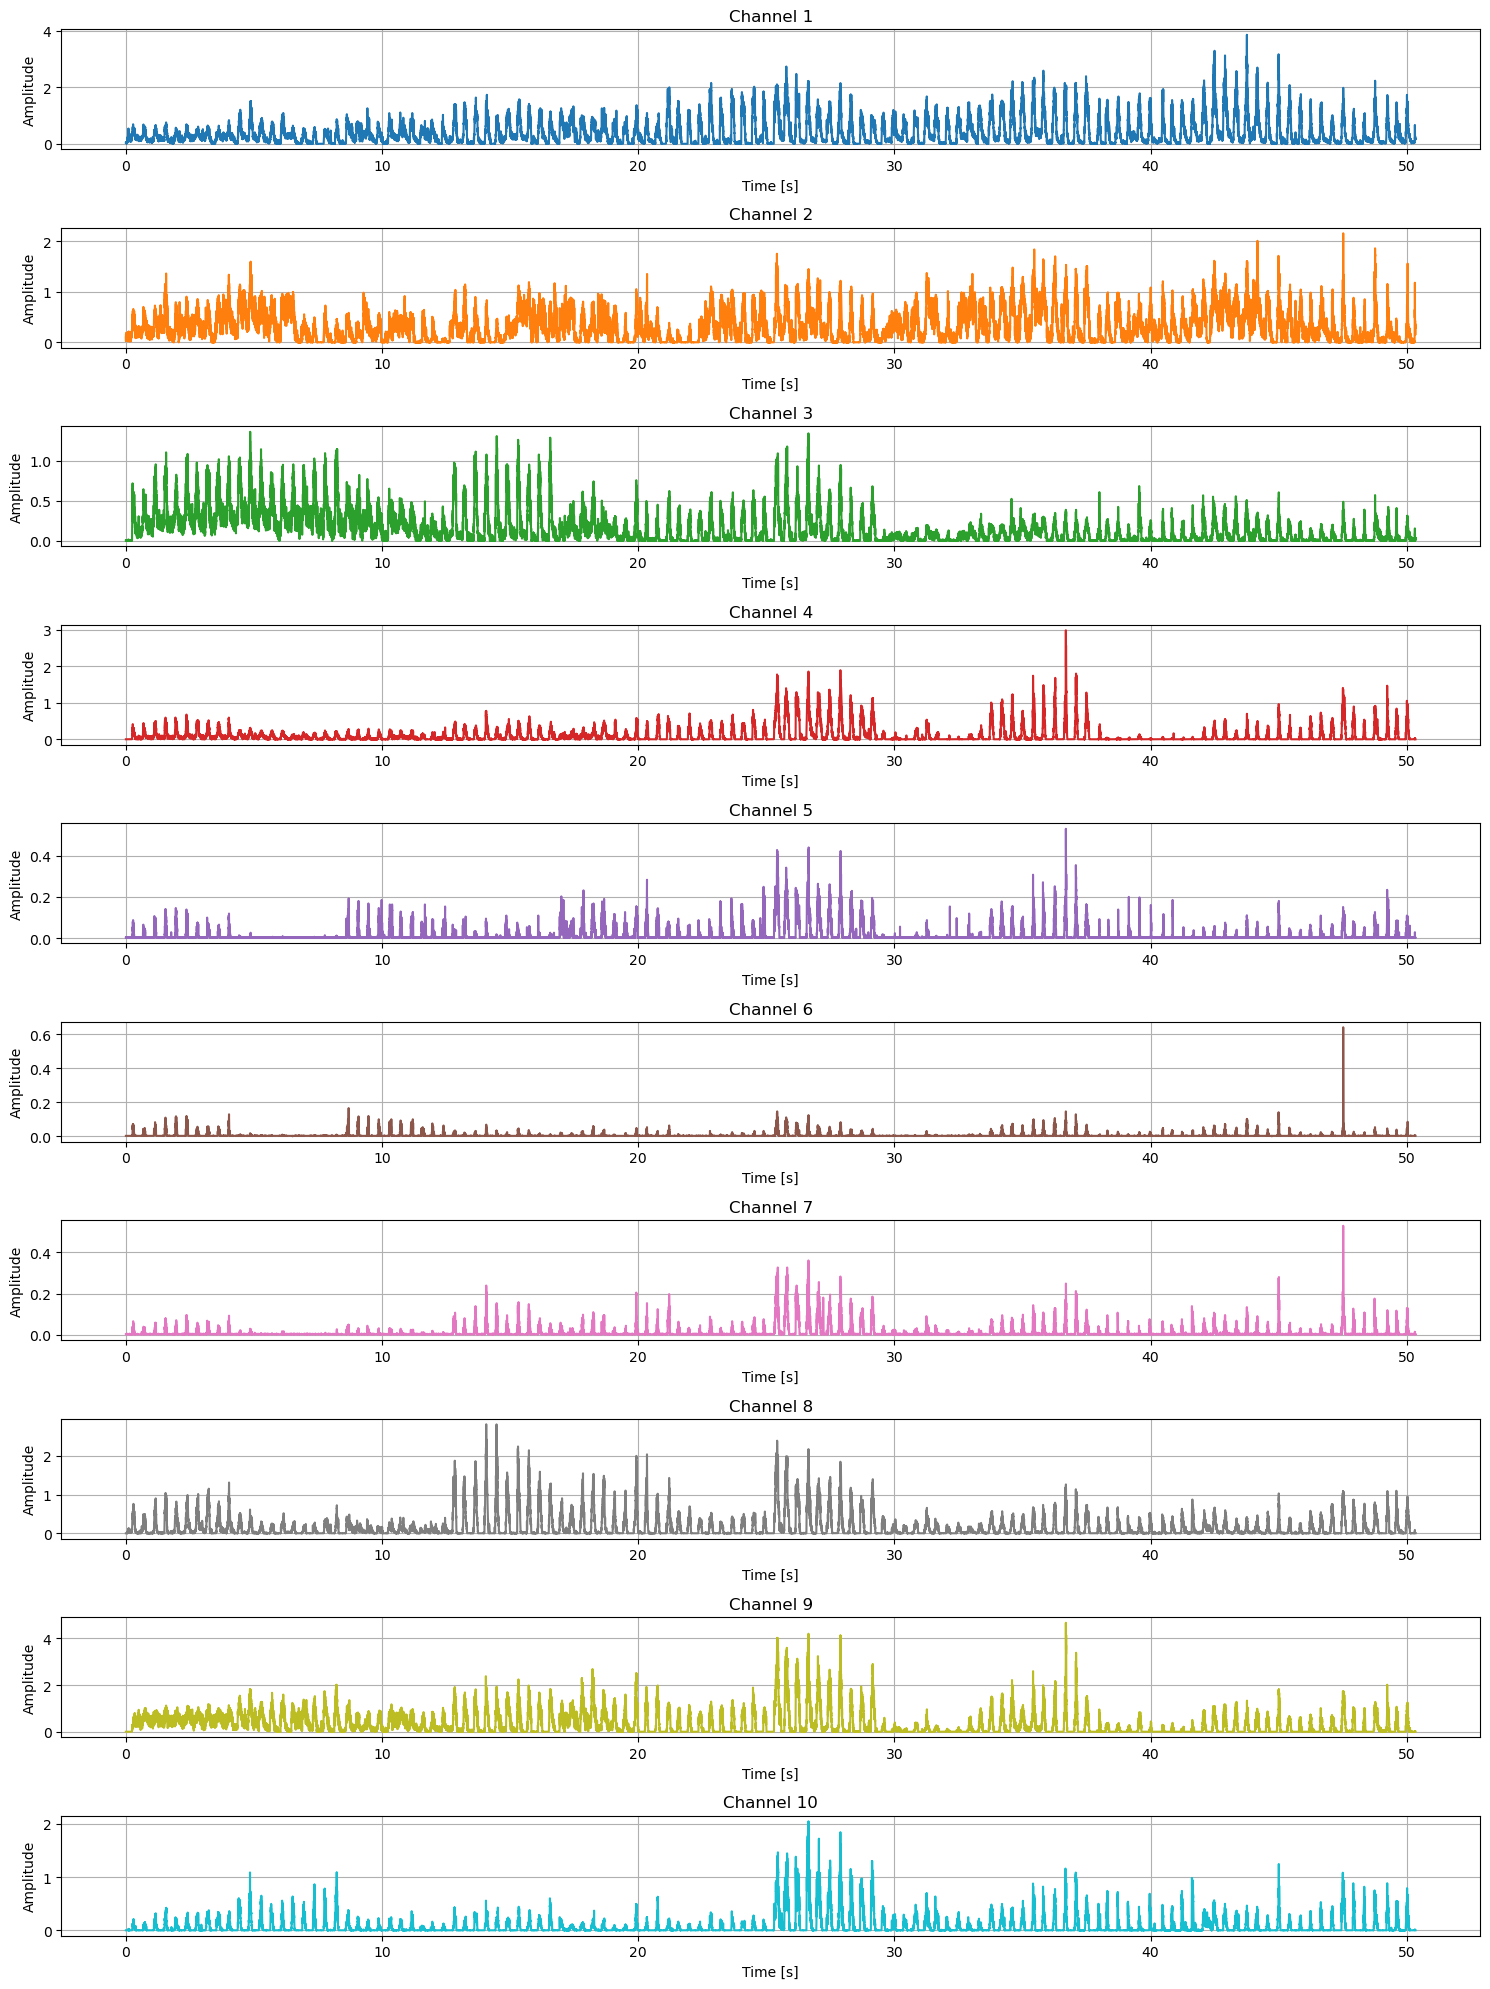

In [4]:
colors = plt.cm.get_cmap('tab10', emg.shape[1]) # Define a color map
num_channels = emg.shape[1] # Number of channels
fs = 2000 # Sampling frequency
time_steps = np.arange(0,emg.shape[0]/fs, 1/fs) # Time vector for plotting

# Plot all channels in a single plot
plt.figure(figsize=(15, 5))
for i in range(num_channels):
    plt.plot(time_steps, emg[:, i], label=f'Channel {i+1}', color=colors(i))
plt.title('Raw EMG Data')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.legend(loc='upper left')
plt.grid()
plt.show()

# Plot each channel in a separate subplot
plt.figure(figsize=(15, 20))
for i in range(num_channels):
    plt.subplot(num_channels, 1, i + 1)
    plt.plot(time_steps, emg[:, i], color=colors(i))
    plt.title(f'Channel {i + 1}')
    plt.xlabel("Time [s]")
    plt.ylabel('Amplitude')
    plt.grid()
plt.tight_layout()
plt.show()

### Preprocess EMG data

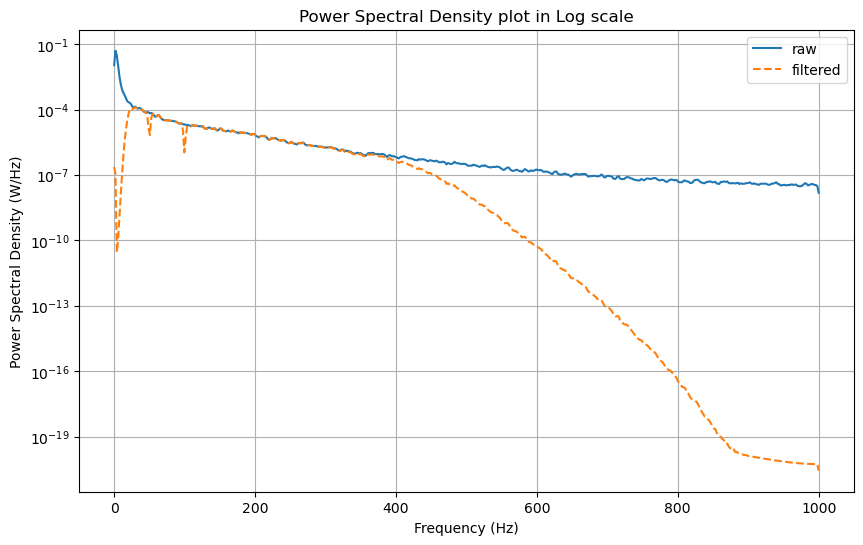

In [5]:
# Apply bandpass filter to the data
emg_filtered = bandpass_filter(emg)

# Plot the power spectrum of the first channel in log scale
freqs_pre, Pxx_pre = welch(emg[:, 0], fs, nperseg=1064)
freqs_post, Pxx_post = welch(emg_filtered[:, 0], fs, nperseg=1064)

# Plot the power spectrum in log scale
plt.figure(figsize=(10, 6))
plt.semilogy(freqs_pre, Pxx_pre, label="raw")
plt.semilogy(freqs_post, Pxx_post, linestyle="--", label="filtered")
plt.legend()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (W/Hz)')
plt.title('Power Spectral Density plot in Log scale')
plt.grid()
plt.show()

# Rectify the signal
emg_rectified = np.abs(emg_filtered)

# Envelop the signal using a moving average filter
mov_mean_size = 200
mov_mean_weights = np.ones(mov_mean_size) / mov_mean_size
emg_envelopes = convolve1d(emg_rectified, weights=mov_mean_weights, axis=0) # convolve1d the rectified signal with the moving average weights

### Visualize preprocessed EMG data

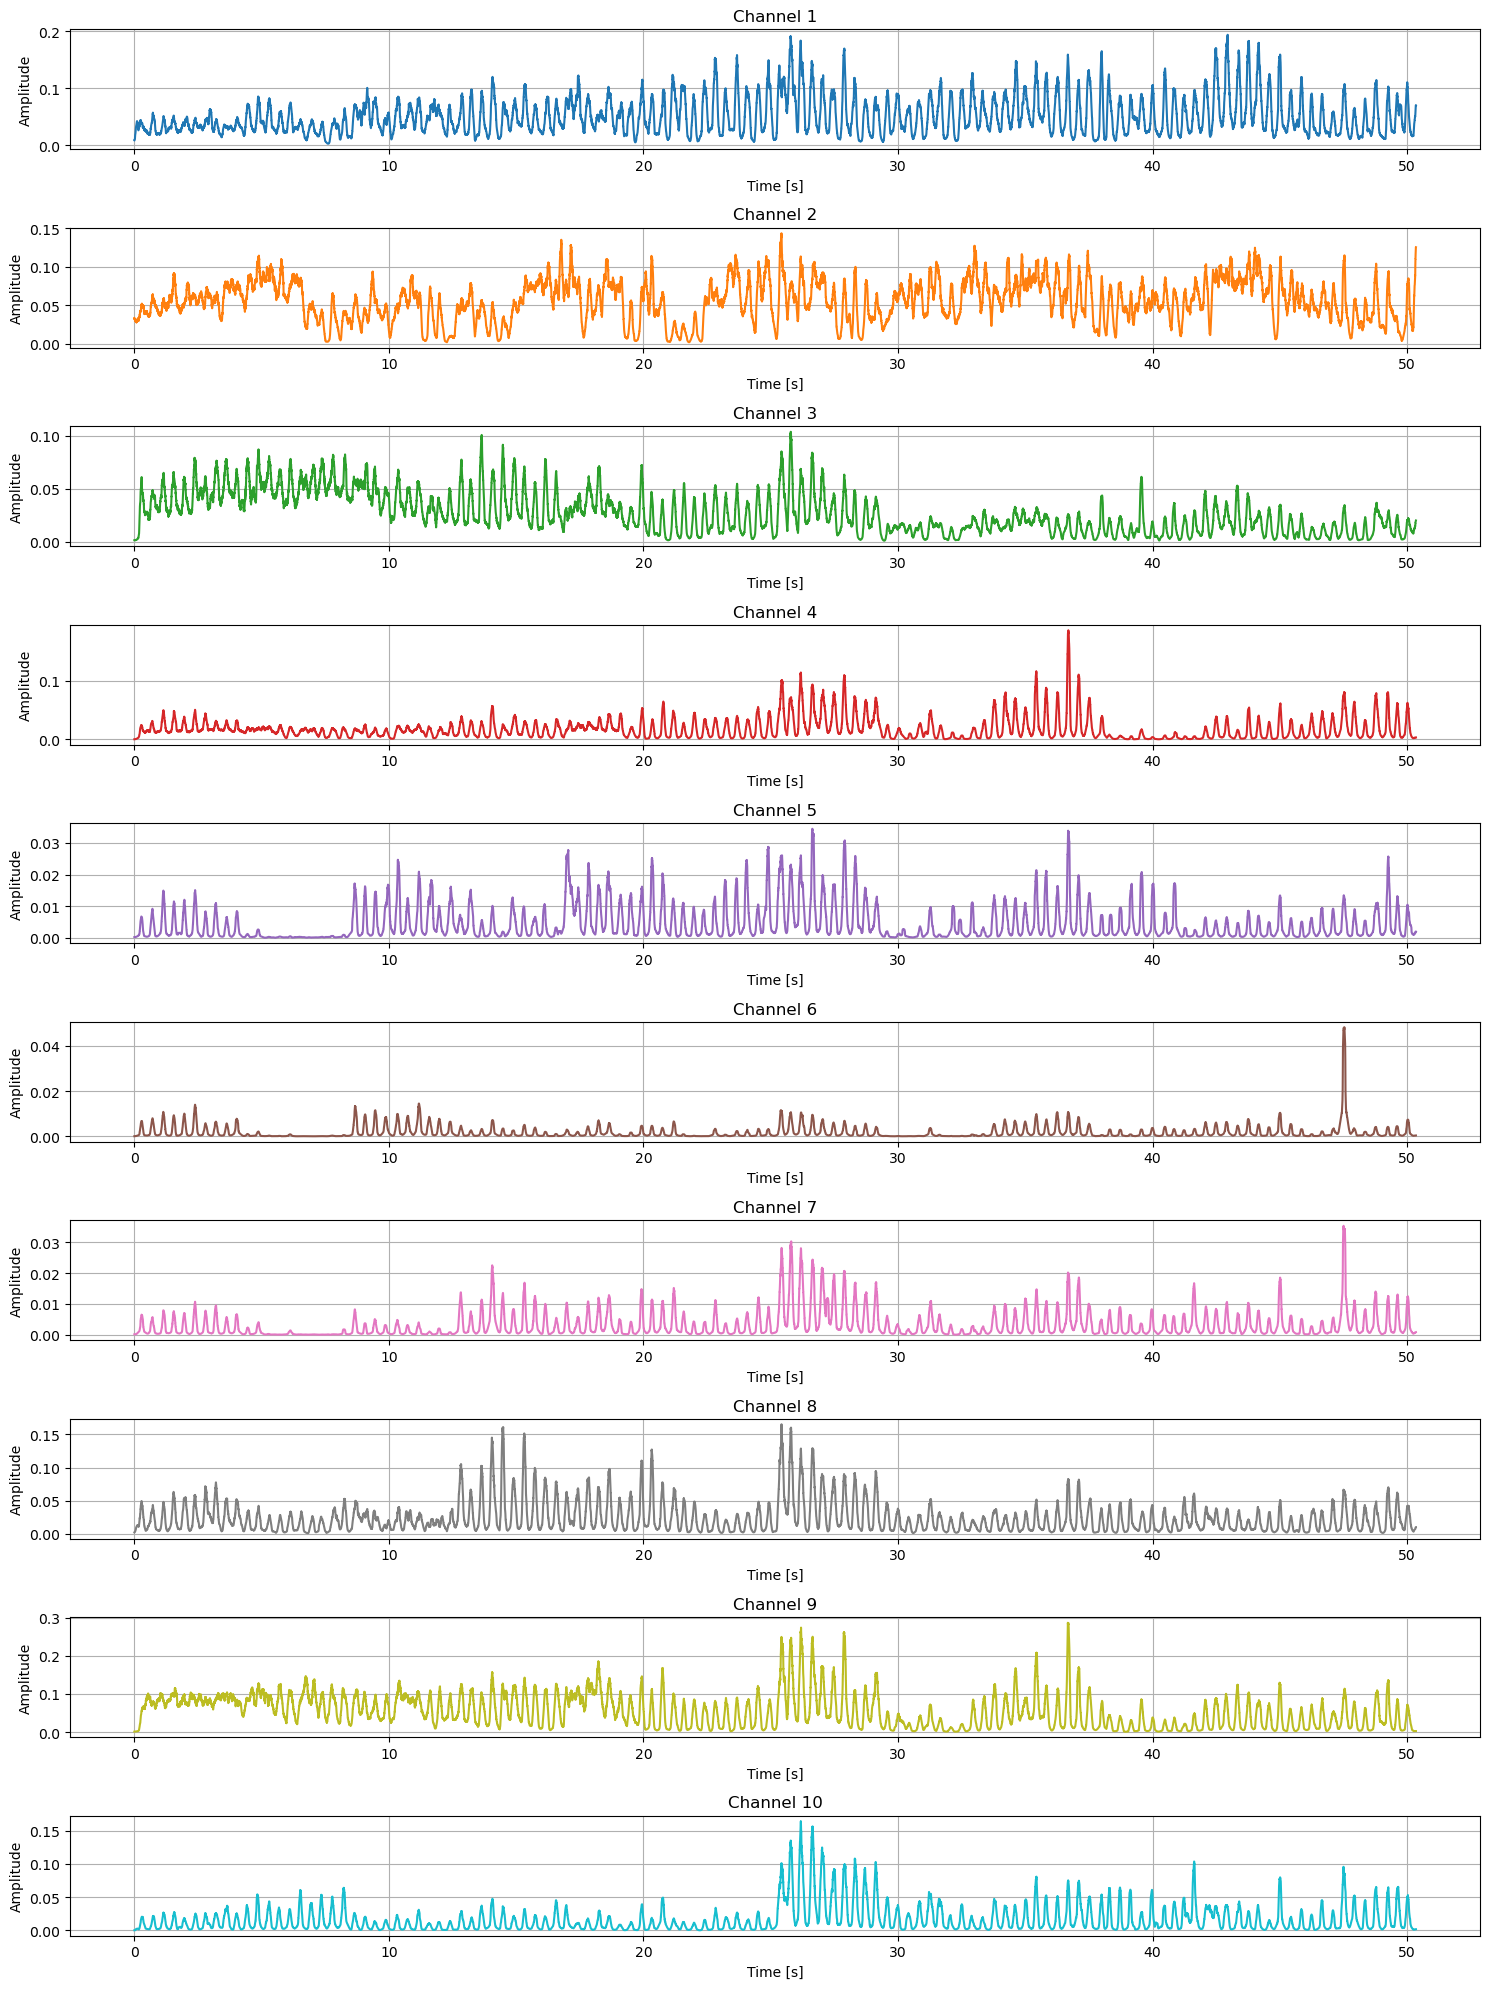

In [6]:
plt.figure(figsize=(15, 20))
for i in range(num_channels):
    plt.subplot(num_channels, 1, i + 1)
    plt.plot(time_steps, emg_envelopes[:, i], color=colors(i))
    plt.title(f'Channel {i + 1}')
    plt.xlabel("Time [s]")
    plt.ylabel('Amplitude')
    plt.grid()
plt.tight_layout()
plt.show()

### Look for possible corruption in the data

In [7]:
# Segment the data into trials based on the stimulus labels
labels = mat_data['stimulus'].flatten()  # Flatten to make it a 1D array
change_points = np.where(np.diff(labels) != 0)[0] + 1
change_points = np.concatenate(([0], change_points, [len(labels)]))

# Segment the data into trials based on the stimulus labels
trials = []
trial_labels = []
for i in range(len(change_points) - 1):
    start_idx = change_points[i]
    end_idx = change_points[i + 1]
    if labels[start_idx] != 0:  # Only include trials where the label is different from 0
        trials.append(emg[start_idx:end_idx])
        trial_labels.append(labels[start_idx])

# Convert trials and trial_labels to numpy arrays
trials = np.array(trials, dtype=object)
trial_labels = np.array(trial_labels)

# Define the number of classes, repetitions, channels
n_stimuli = len(np.unique(stimulus)) - 1 
n_repetitions = len(np.unique(repetition)) - 1 
n_channels = emg_rectified.shape[1]

# Initialize a 2D array to store the number of samples per trial
number_of_samples_per_trial = np.zeros((n_stimuli, n_repetitions))

for stimuli_idx in range(n_stimuli):
    for repetition_idx in range(n_repetitions):
        
        idx = np.logical_and(stimulus == stimuli_idx+1, repetition == repetition_idx+1)
        number_of_samples_per_trial[stimuli_idx, repetition_idx] = np.sum(idx.astype(int))

# Print the number of trials and the shape of each trial
print(f"Number of trials: {len(trials)}\n")
print("Number of samples per trial:")
print(number_of_samples_per_trial)

Number of trials: 120

Number of samples per trial:
[[512. 512. 512. 512. 512. 512. 512. 512. 512. 512.]
 [516. 517. 516. 516. 516. 516. 516. 520. 516. 520.]
 [512. 512. 516. 512. 513. 512. 516. 512. 513. 512.]
 [516. 516. 516. 516. 516. 516. 516. 517. 516. 516.]
 [520. 517. 516. 516. 516. 516. 516. 516. 516. 520.]
 [516. 520. 516. 516. 517. 516. 516. 516. 517. 520.]
 [516. 516. 520. 516. 516. 516. 517. 516. 516. 516.]
 [517. 516. 516. 520. 516. 516. 516. 520. 516. 516.]
 [512. 512. 512. 513. 512. 512. 512. 513. 520. 512.]
 [512. 512. 512. 512. 512. 512. 512. 512. 516. 516.]
 [517. 516. 516. 516. 517. 520. 516. 516. 516. 517.]
 [516. 516. 516. 517. 516. 516. 516. 517. 520. 516.]]


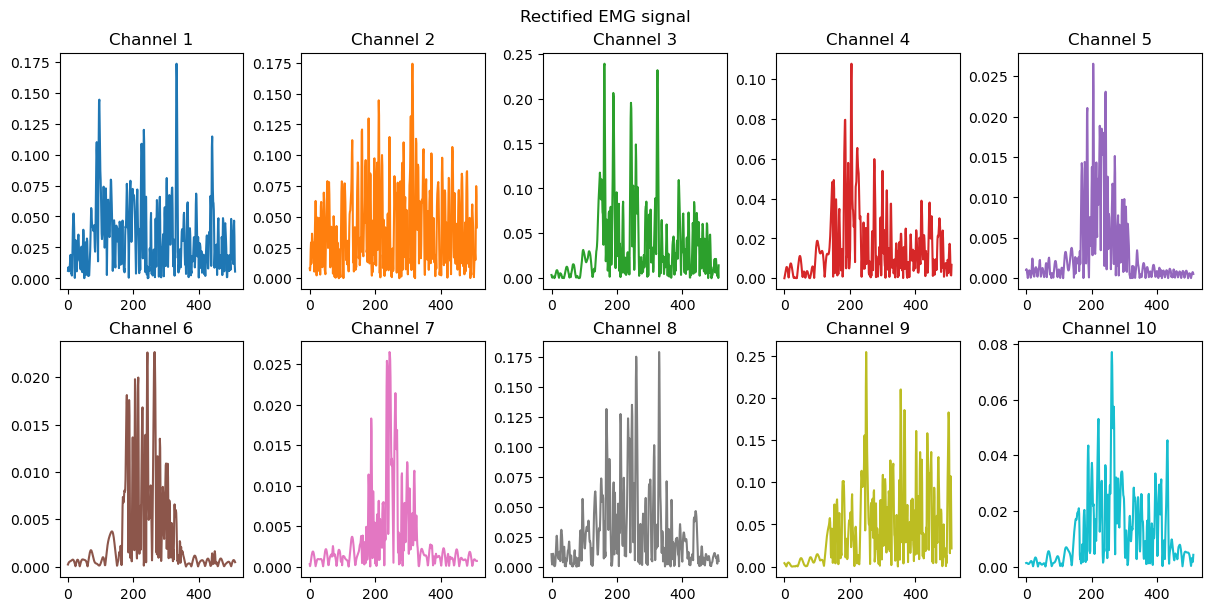

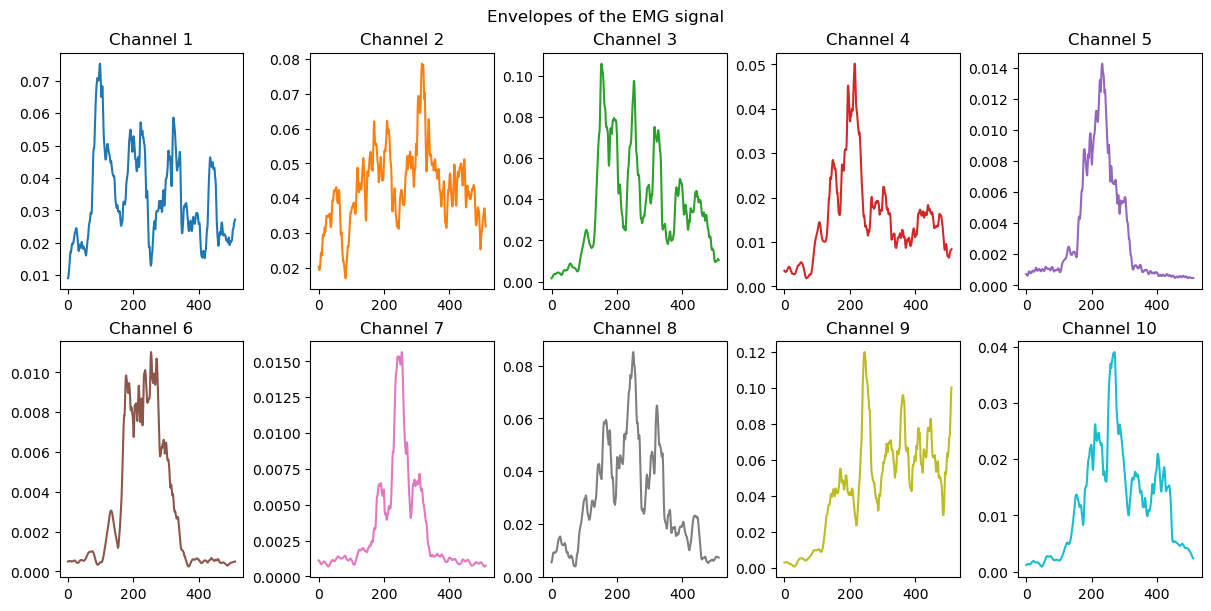

In [8]:
# Define the length of the moving average window
mov_mean_length = 25
mov_mean_weights = np.ones(mov_mean_length) / mov_mean_length

# Initialize the data structure
emg_windows = [[None for _ in range(n_repetitions)] for _ in range(n_stimuli)]
emg_envelopes = [[None for _ in range(n_repetitions)] for _ in range(n_stimuli)]

for stimuli_idx in range(n_stimuli):
    for repetition_idx in range(n_repetitions):
        idx = np.logical_and(stimulus == stimuli_idx + 1, repetition == repetition_idx + 1).flatten()
        emg_windows[stimuli_idx][repetition_idx] = emg_rectified[idx, :]
        emg_envelopes[stimuli_idx][repetition_idx] = convolve1d(emg_windows[stimuli_idx][repetition_idx], mov_mean_weights, axis=0)

# Plot rectified EMG signal
fig, ax = plt.subplots(2, 5, figsize=(12, 6), constrained_layout=True)
ax = ax.ravel()
number_of_emg_channels = emg_rectified.shape[-1]  # 10 EMG channels

for i in range(number_of_emg_channels): 
    ax[i].plot(emg_windows[0][0][:, i], color=colors(i))
    ax[i].set_title(f"Channel {i+1}")
plt.suptitle("Rectified EMG signal")
plt.show()

# Plot envelopes of the EMG signal
fig, ax = plt.subplots(2, 5, figsize=(12, 6), constrained_layout=True)
ax = ax.ravel()

for i in range(number_of_emg_channels): 
    ax[i].plot(emg_envelopes[0][0][:, i], color=colors(i))
    ax[i].set_title(f"Channel {i+1}")
plt.suptitle("Envelopes of the EMG signal")
plt.show()

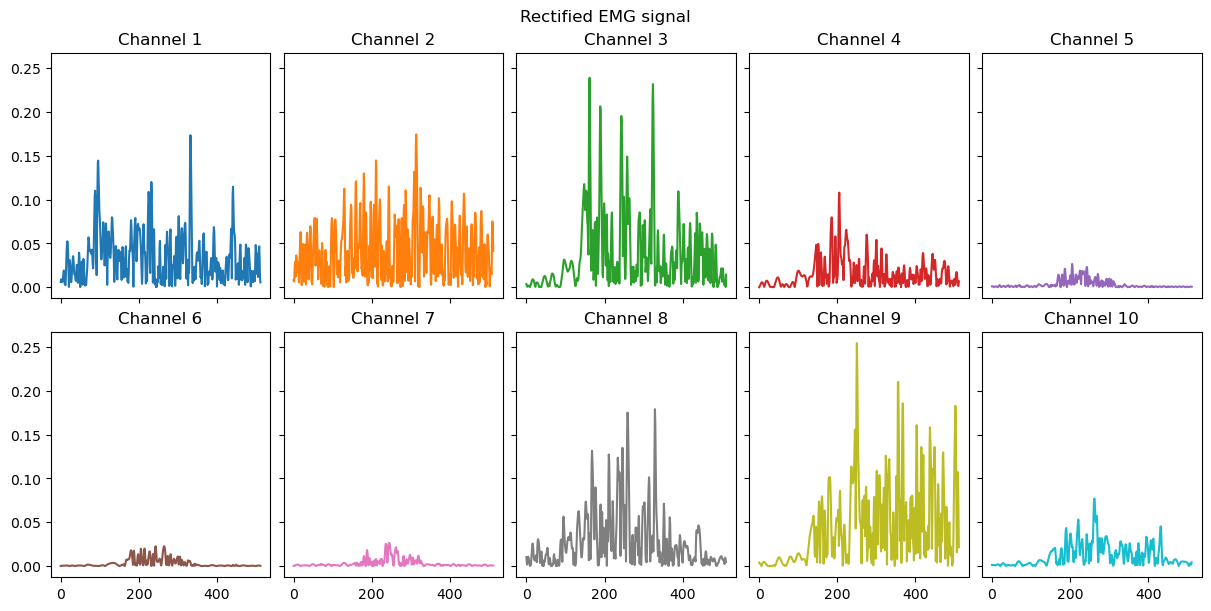

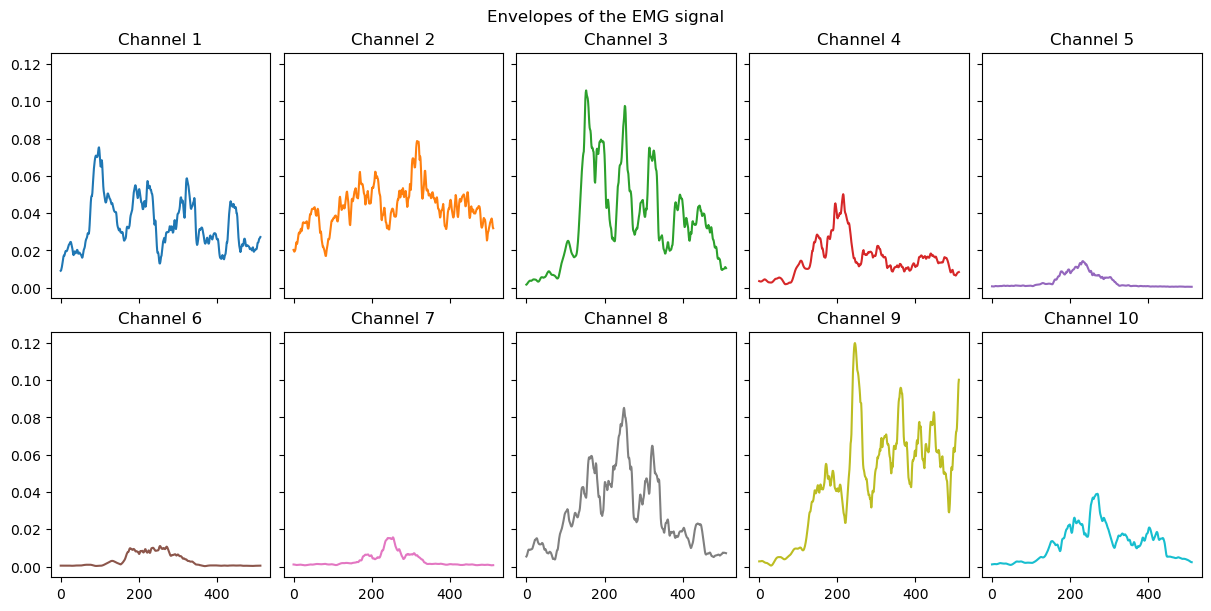

In [9]:
# Now we plot all the channels on the same y-scale
fig, ax = plt.subplots(2, 5, figsize=(12, 6), constrained_layout=True, sharex=True, sharey=True)
ax = ax.ravel()
number_of_emg_channels = emg_rectified.shape[-1]

# Plot rectified EMG signal
for i in range(number_of_emg_channels): 
    ax[i].plot(emg_windows[0][0][:, i], color=colors(i))
    ax[i].set_title(f"Channel {i+1}")
plt.suptitle("Rectified EMG signal")
plt.show()

# Plot envelopes of the EMG signal
fig, ax = plt.subplots(2, 5, figsize=(12, 6), constrained_layout=True, sharex=True, sharey=True)
ax = ax.ravel()

for i in range(number_of_emg_channels): 
    ax[i].plot(emg_envelopes[0][0][:, i], color=colors(i))
    ax[i].set_title(f"Channel {i+1}")
plt.suptitle("Envelopes of the EMG signal")
plt.show()

Text(0.5, 0.98, 'Envelopes of the EMG signal')

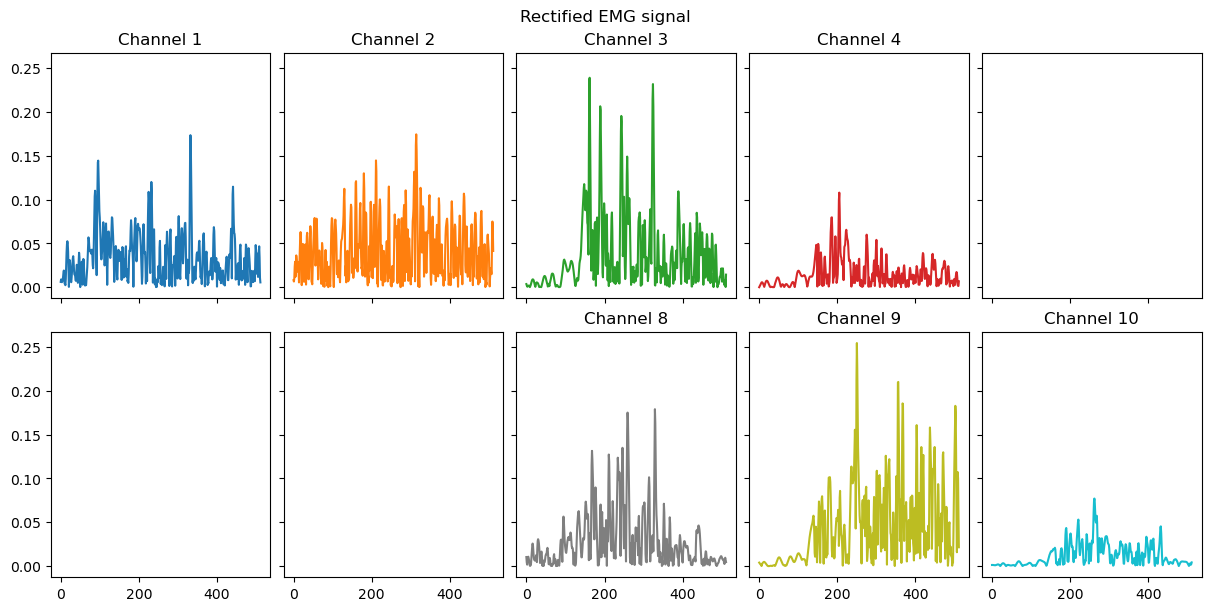

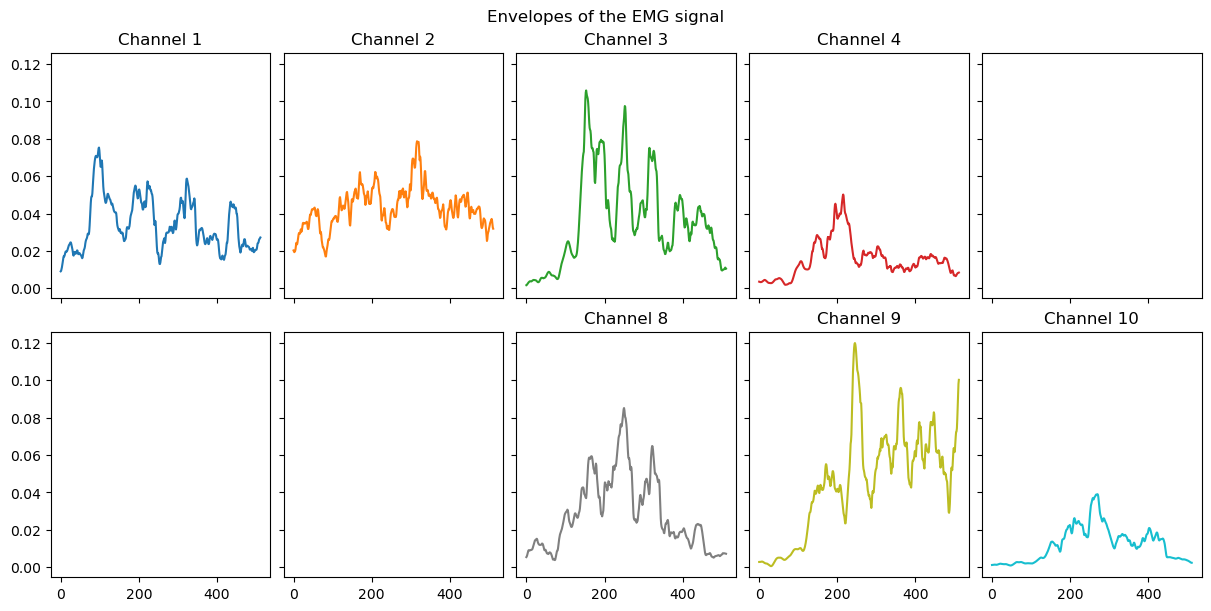

In [10]:
plt.close("all")
fig, ax = plt.subplots(2, 5, figsize=(12, 6), constrained_layout=True, sharex=True, sharey=True)
ax = ax.ravel()
number_of_emg_channels = emg_rectified.shape[-1]

# Plot rectified EMG signal skipping corrupted channels
for i in range(number_of_emg_channels): 
    if i in [4, 5, 6]:
        continue
    ax[i].plot(emg_windows[0][0][:, i], color=colors(i))
    ax[i].set_title(f"Channel {i+1}")
plt.suptitle("Rectified EMG signal")

# Plot envelopes of the EMG signal skipping corrupted channels
fig, ax = plt.subplots(2, 5, figsize=(12, 6), constrained_layout=True, sharex=True, sharey=True)
ax = ax.ravel()
for i in range(number_of_emg_channels): 
    if i in [4, 5, 6]:
        continue
    ax[i].plot(emg_envelopes[0][0][:, i], color=colors(i))
    ax[i].set_title(f"Channel {i+1}")
plt.suptitle("Envelopes of the EMG signal")

### Visualizing across repetitions

In [11]:
# Calculate the average activation for each channel, stimulus, and repetition
emg_average_activations = np.zeros((n_channels, n_stimuli, n_repetitions))
for stimuli_idx in range(n_stimuli):
    for repetition_idx in range(n_repetitions):
        # Mean across time for each channel
        emg_average_activations[:, stimuli_idx, repetition_idx] = np.mean(emg_envelopes[stimuli_idx][repetition_idx], axis=0)

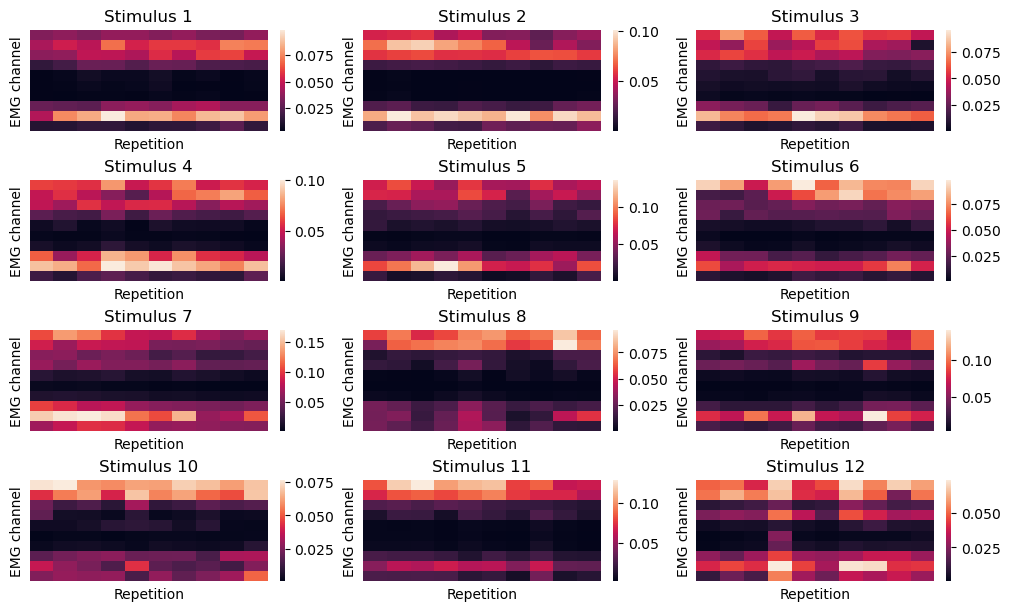

In [12]:
# Plot the average activations as heatmaps
fig, ax = plt.subplots(4, 3, figsize=(10, 6), constrained_layout=True, sharex=True, sharey=True)
ax = ax.ravel()

for stimuli_idx in range(n_stimuli):
    sns.heatmap(np.squeeze(emg_average_activations[:, stimuli_idx, :]), ax=ax[stimuli_idx], xticklabels=False, yticklabels=False, cbar=True)
    ax[stimuli_idx].title.set_text(f"Stimulus {stimuli_idx + 1}")
    ax[stimuli_idx].set_xlabel("Repetition")
    ax[stimuli_idx].set_ylabel("EMG channel")

plt.show()

Does the structure seem homogeneous by row? Why?

The rows represent the activity recorded by each channel in response to repeated stimuli. There appears to be a notable homogeneity across the rows, which aligns with expectations. Since each channel is exposed to the same stimulus, it's logical that they would capture similar muscular activities. This consistency suggests that the channels are functioning correctly and are reliably capturing the stimulus-induced activity.

Does the structure seem homogeneous by column? Why?

The columns correspond to each repetition of the stimulus. Variability across columns is expected due to several factors. Firstly, not all muscles are equally activated with each stimulus repetition, leading to differences in the recorded activity. Additionally, the impedance of each channel may vary, affecting the amplitude of the recorded signals. Therefore, the amplitude alone may not be a reliable metric for comparing channel responses. 

What can we say comparing the EMG recordings for different stimuli?

At a preliminary glance, it appears that different stimuli elicit activation in different muscle groups. However, a more thorough analysis is required to confirm this observation. One approach could be to normalize the signals, making them more comparable across channels. This normalization would help in identifying specific patterns of muscle activation unique to each stimulus, providing deeper insights into the neuromuscular responses elicited by different stimuli.

**Question:** 

Does the data look reasonable? Did you need to remove any trials?

**Answer:** 

**[TO COMPLETE]**

### Split the data into training, validation, and testing sets

In [13]:
# Define the split ratios
train_ratio = 0.7
validation_ratio = 0.15
test_ratio = 0.15

emg_train, emg_temp, labels_train, labels_temp = train_test_split(emg, stimulus, test_size=(1 - train_ratio), random_state=42)

# Then, split the temp set into validation and test sets
emg_val, emg_test, labels_val, labels_test = train_test_split(emg_temp, labels_temp, test_size=(test_ratio / (test_ratio + validation_ratio)), random_state=42)

# Print the shapes of the resulting datasets
print("Training data shape:", emg_train.shape, ", Training labels shape:", labels_train.shape)
print("Validation data shape:", emg_val.shape, ", Validation labels shape:", labels_val.shape)
print("Testing data shape:", emg_test.shape, ", Testing labels shape:", labels_test.shape)

Training data shape: (70480, 10) , Training labels shape: (70480, 1)
Validation data shape: (15103, 10) , Validation labels shape: (15103, 1)
Testing data shape: (15103, 10) , Testing labels shape: (15103, 1)


**Question:** 

Why do we need the different datasets?

**Answer:** 

Different datasets are used to ensure a machine learning model generalizes well to new data. The training set is used to learn and adjust model parameters, the validation set is used to tune hyperparameters and select the best model configuration, and the testing set provides an unbiased evaluation of the final model's performance on unseen data. This approach helps prevent overfitting and ensures the model performs well in real-world applications.

### Extract features from the trials

In [14]:
# Define the features

# Mean absolute value (MAV)
mav = lambda x: np.mean(np.abs(x))
# Standard Deviation (STD)
std = lambda x: np.std(x)
# Maximum absolute Value (MaxAV)
maxav = lambda x: np.max(np.abs(x))
# Root mean square (RMS)
rms = lambda x: np.sqrt(np.mean(x**2))
# Waveform length (WL)
wl = lambda x: np.sum(np.abs(np.diff(x)))
# Slope sign changes (SSC)
ssc = lambda x: np.sum((np.diff(x[:-1]) * np.diff(x[1:])) < 0)

In [15]:
# Build the dataset and labels
dataset, labels = build_dataset_from_ninapro(
    emg=emg,
    stimulus=stimulus,
    repetition=repetition,
    features=[mav, std, maxav, rms, wl, ssc, total_power],
)

print(f"Dataset dimension: {dataset.shape}")
print(f"Labels dimension: {labels.shape}")

Dataset dimension: (120, 70)
Labels dimension: (120,)


### Look at the typical values of the features across the different trials

In [16]:
# Use the dataset in place of features
num_trials, num_features = dataset.shape
num_channels = emg.shape[1]  # Number of channels
num_feature_types = num_features // num_channels  # Number of feature types

# Generate feature names
feature_types = ['MAV', 'STD', 'MaxAV', 'RMS', 'WL', 'SSC', 'TotalPower']
feature_names = []
for i in range(num_channels):
    for feature_type in feature_types:
        feature_names.append(f'{feature_type}_{i+1}')

# Convert the dataset to a DataFrame for easier analysis
features_df = pd.DataFrame(dataset, columns=feature_names)

# Compute and print summary statistics
summary_stats = features_df.describe()
print(summary_stats)

            MAV_1       STD_1     MaxAV_1       RMS_1        WL_1       SSC_1  \
count  120.000000  120.000000  120.000000  120.000000  120.000000  120.000000   
mean     0.572508    0.410077    1.504862    0.708849   12.909727  129.008333   
std      0.232935    0.180509    0.633277    0.283283    4.081252   16.149770   
min      0.176969    0.103011    0.542000    0.256354    5.469600   79.000000   
25%      0.385478    0.268454    1.073575    0.493825   10.011575  121.000000   
50%      0.541059    0.400245    1.442850    0.685056   12.380150  129.000000   
75%      0.690710    0.523141    1.840225    0.837655   14.713300  139.000000   
max      1.352553    0.947333    3.864700    1.588166   25.083200  164.000000   

       TotalPower_1       MAV_2       STD_2     MaxAV_2  ...        WL_9  \
count    120.000000  120.000000  120.000000  120.000000  ...  120.000000   
mean       0.011380    0.402512    0.236276    1.005611  ...   15.340584   
std        0.009529    0.187256    0.09048

/var/folders/q_/xhgs30s966s2xsy_tl8w2k680000gp/T/ipykernel_62026/1559300586.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', num_channels)
/var/folders/q_/xhgs30s966s2xsy_tl8w2k680000gp/T/ipykernel_62026/1559300586.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.errorbar(indices, summary_stats.loc['mean'][indices], yerr=summary_stats.loc['std'][indices], fmt='o', ecolor=colors(i), capsize=5, label=f'Channel {i+1}')


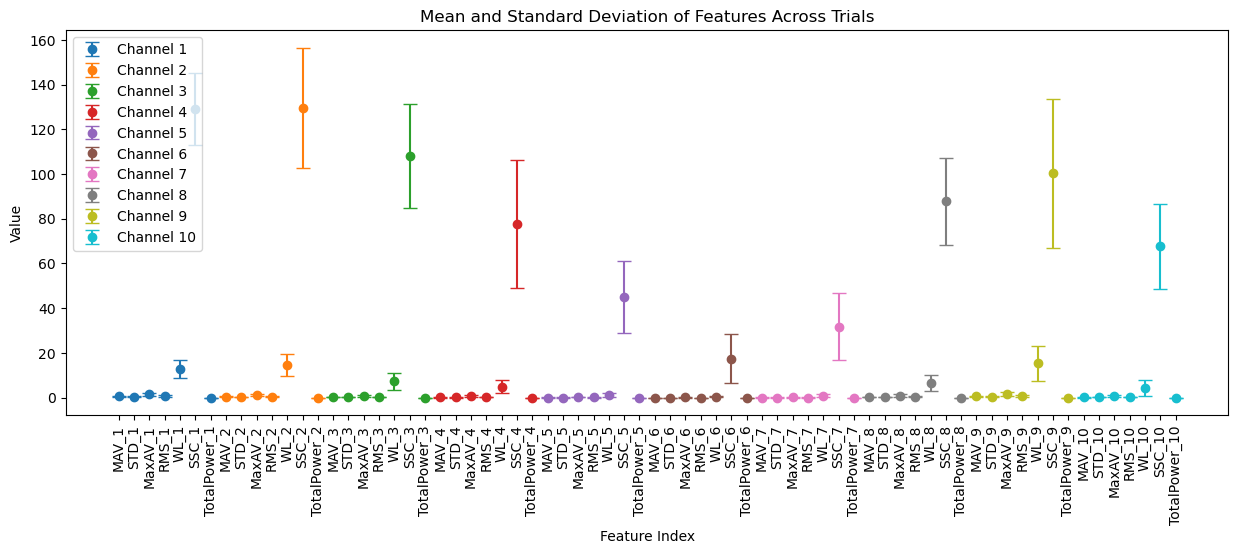

In [17]:
# Define a color map
colors = plt.cm.get_cmap('tab10', num_channels)

# Plot the mean and standard deviation of each feature for each channel
plt.figure(figsize=(15, 5))
for i in range(num_channels):
    start_index = i * num_feature_types
    end_index = start_index + num_feature_types
    indices = list(range(start_index, end_index))
    plt.errorbar(indices, summary_stats.loc['mean'][indices], yerr=summary_stats.loc['std'][indices], fmt='o', ecolor=colors(i), capsize=5, label=f'Channel {i+1}')
plt.title('Mean and Standard Deviation of Features Across Trials')
plt.xlabel('Feature Index')
plt.ylabel('Value')
plt.xticks(ticks=range(num_features), labels=feature_names, rotation=90)
plt.legend(loc='upper left')
plt.show()

/var/folders/q_/xhgs30s966s2xsy_tl8w2k680000gp/T/ipykernel_62026/3580265168.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Plotting {feature_type} for Channel {j+1}: mean={summary_stats.loc['mean'][index]}, std={summary_stats.loc['std'][index]}")
/var/folders/q_/xhgs30s966s2xsy_tl8w2k680000gp/T/ipykernel_62026/3580265168.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.errorbar(j, summary_stats.loc['mean'][index], yerr=summary_stats.loc['std'][index], fmt='o', ecolor=colors(j), capsize=5, label=f'Channel {j+1}' if i == 0 else "")
/var/folders/q_/xhgs30s966s2xsy_tl8w2k680000gp/T/ipykernel_62026/3580

Plotting MAV for Channel 1: mean=0.5725083436554115, std=0.2329351646704174
Plotting MAV for Channel 2: mean=0.4025118887743038, std=0.1872560986727242
Plotting MAV for Channel 3: mean=0.21360230589577497, std=0.1477160343475568
Plotting MAV for Channel 4: mean=0.1672700474785308, std=0.14526371595544368
Plotting MAV for Channel 5: mean=0.0233533730636963, std=0.024263099126905135
Plotting MAV for Channel 6: mean=0.008296240963850567, std=0.00658020242525
Plotting MAV for Channel 7: mean=0.016705212335548742, std=0.018823345200772206
Plotting MAV for Channel 8: mean=0.24474754146413555, std=0.17172564075925872
Plotting MAV for Channel 9: mean=0.4822213902517008, std=0.3040545062724958
Plotting MAV for Channel 10: mean=0.13144170518922332, std=0.11508296448682132
Plotting STD for Channel 1: mean=0.41007657037413525, std=0.1805086635340304
Plotting STD for Channel 2: mean=0.236275946074701, std=0.09048921127714211
Plotting STD for Channel 3: mean=0.14785214477290048, std=0.08660730721935

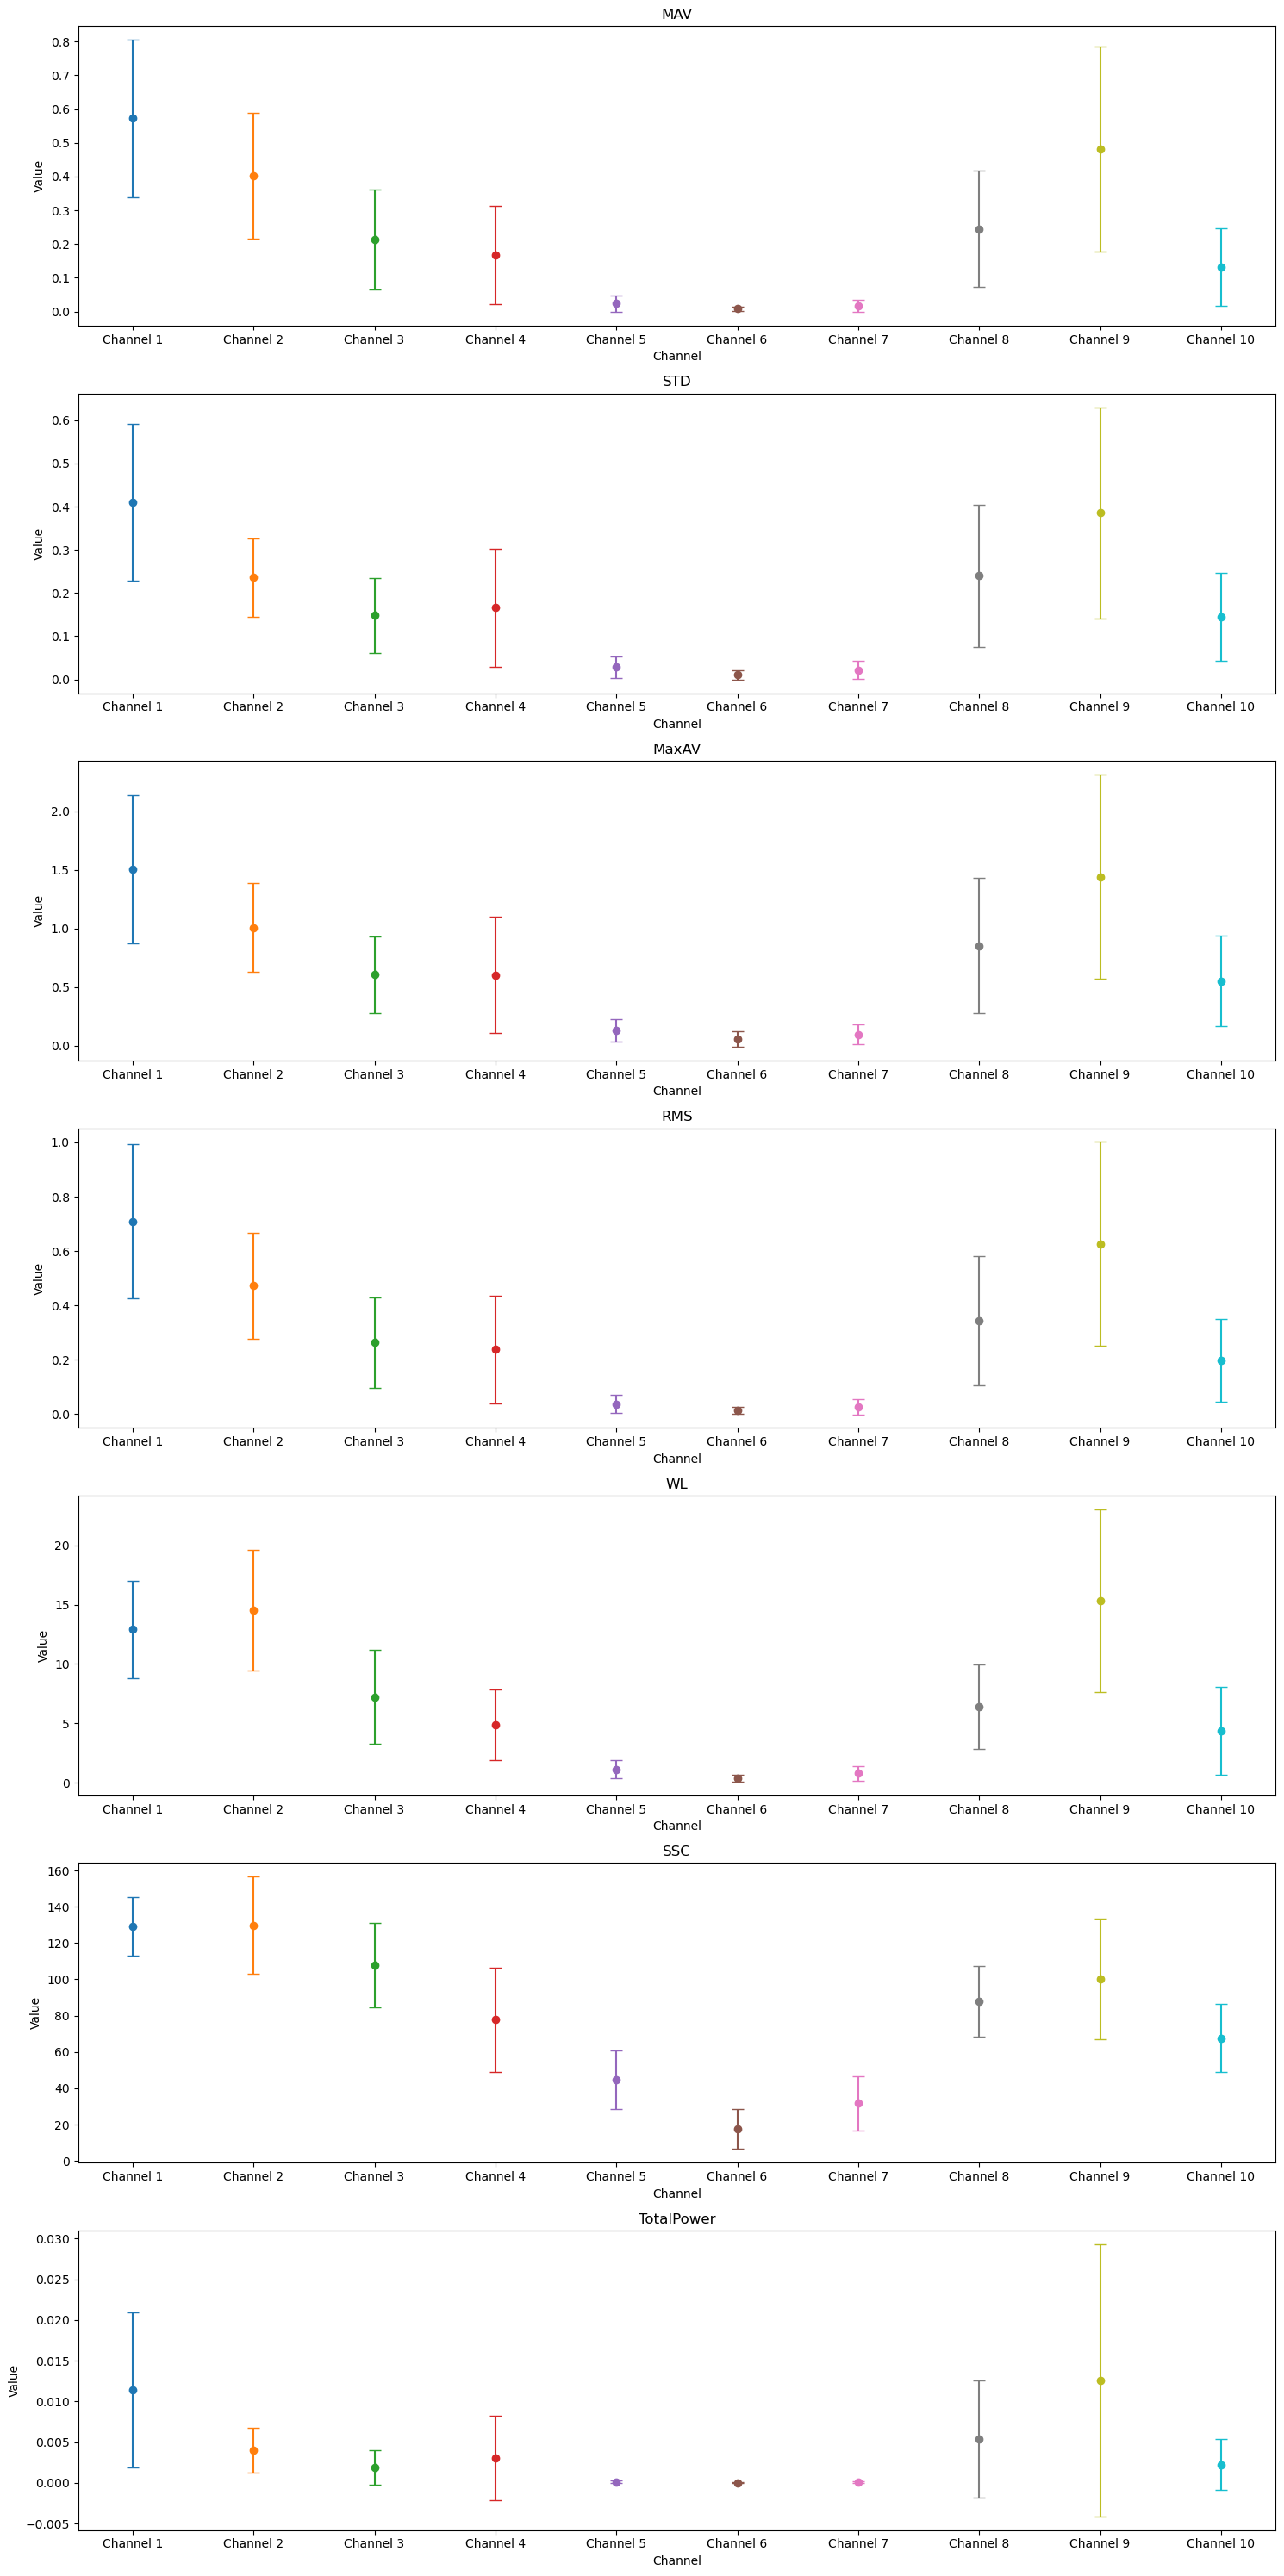

In [18]:
# Plot the mean and standard deviation of each feature type for each channel
fig, axes = plt.subplots(num_feature_types, 1, figsize=(15, 30))
for i, feature_type in enumerate(feature_types):
    ax = axes[i]
    for j in range(num_channels):
        index = j * num_feature_types + i
        print(f"Plotting {feature_type} for Channel {j+1}: mean={summary_stats.loc['mean'][index]}, std={summary_stats.loc['std'][index]}")
        ax.errorbar(j, summary_stats.loc['mean'][index], yerr=summary_stats.loc['std'][index], fmt='o', ecolor=colors(j), capsize=5, label=f'Channel {j+1}' if i == 0 else "")
    ax.set_title(f'{feature_type}')
    ax.set_xlabel('Channel')
    ax.set_ylabel('Value')
    ax.set_xticks(range(num_channels))
    ax.set_xticklabels([f'Channel {j+1}' for j in range(num_channels)])

plt.tight_layout()
plt.show()

**Question:** 

What do you see? Are the values similar between repetitions and between channels? Explain the possible reasons for similarity/discrepancies.

**Answer:** 

In most channels, we know that the values are similar between repetitions because the mean values of the features for each channel have relatively small standard deviations, as shown by the error bars in the plots, indicating a stable and repeatable EMG signals for the same movements. 

However, there are noticeable differences in feature values between channels. These discrepancies can be attributed to factors such as variations in electrode placement, differences in muscle activation, and varying levels of signal noise, highlighting the impact of physiological and technical factors on EMG signal characteristics.

### Perform classification on the data (Random Forest)

Accuracy score: 0.9166666666666666


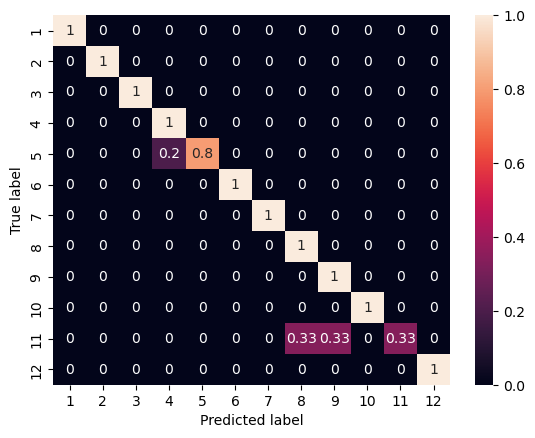

In [19]:
# Split the dataset into training and testing sets
# Here, 30% of the data is reserved for testing, and 70% is used for training
X_train, X_test, y_train, y_test = train_test_split(dataset, labels, test_size=0.3, random_state=42)

# Normalizing the data
# StandardScaler is used to scale the features so that they have a mean of 0 and a standard deviation of 1
scaler = StandardScaler()
X_train_z = scaler.fit_transform(X_train)  # Fit the scaler on the training data and transform it
X_test_z = scaler.transform(X_test)        # Transform the test data using the same scaler

# Train a classifier on the normalized data
# We are using RandomForestClassifier from sklearn
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_z, y_train)  # Fit the model on the training data

# Evaluate the classifier on the test set
# Predict the labels for the test set
y_pred = clf.predict(X_test_z)
# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy score: {accuracy}")

# Create a confusion matrix to visualize the performance of the classification
# The confusion matrix shows the true vs predicted labels
confmat = confusion_matrix(y_test, y_pred, normalize="true")
fig, ax = plt.subplots()
sns.heatmap(confmat, annot=True, ax=ax)  # Use seaborn to create a heatmap of the confusion matrix
ax.set_ylabel("True label")
ax.set_xlabel("Predicted label")
ax.set_xticklabels(range(1, len(confmat) + 1))
ax.set_yticklabels(range(1, len(confmat) + 1))
plt.show()

In [20]:
# perform cross-validation
scores = cross_val_score(clf, X_train_z, y_train, cv=5)
print(f"Accuracy scores of all models: {scores}")
print(f"Mean accuracy across all models: {np.mean(scores)}")

Accuracy scores of all models: [0.88235294 0.76470588 0.88235294 0.64705882 0.9375    ]
Mean accuracy across all models: 0.8227941176470587


In [21]:
# Define the parameter grid for RandomForestClassifier
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "bootstrap": [True, False]
}

# Initialize GridSearchCV with RandomForestClassifier
grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, n_jobs=-1)
grid.fit(X_train_z, y_train)

print(f"Best estimator: {grid.best_estimator_}")
print(f"Best hyperparameters: {grid.best_params_}")

# Predict the labels for the test set using the best model
y_pred = grid.predict(X_test_z)

# Calculate the accuracy of the best model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy score of best model: {accuracy}")

Best estimator: RandomForestClassifier(min_samples_split=5, n_estimators=50, random_state=42)
Best hyperparameters: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
Accuracy score of best model: 0.8888888888888888


### Evaluate performance

Estimated mutual information between each feature and the target:
 [0.7590356  0.8392817  0.88531811 0.84350562 0.71708551 0.09839784
 0.85205703 0.27714487 0.54844247 0.37739511 0.25859191 0.2611349
 0.14462222 0.30557396 0.8090134  0.84586194 0.61761765 0.75198843
 0.80771381 0.44472347 0.8345599  0.95650563 0.93345225 0.80056255
 0.96940346 0.8552934  0.82822247 0.89571287 0.8231328  0.6580136
 0.61119935 0.66229399 0.88599449 0.45047628 0.51618646 0.54019193
 0.56763426 0.53173385 0.53653308 0.78076891 0.53218818 0.49758867
 0.57420919 0.53965719 0.51831469 0.55494077 0.73220477 0.53962645
 0.46393575 0.77180223 0.73048334 0.6914949  0.75762138 0.74655769
 0.28118352 0.77236373 0.91882727 0.82052901 0.76618286 0.90924342
 0.86491962 0.59767387 0.85442038 0.65943413 0.66433912 0.6097185
 0.62361162 0.73602036 0.31497056 0.67007901]

Accuracy score of a model with k best features: 0.8888888888888888


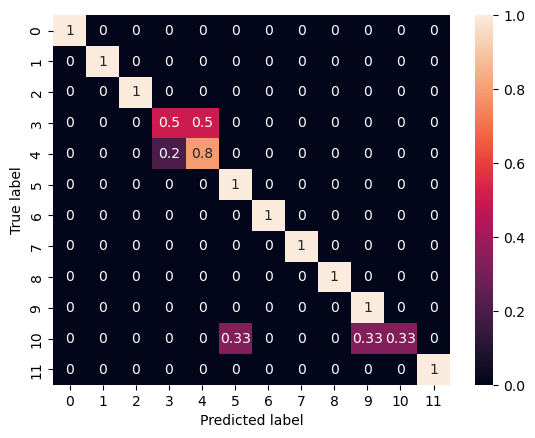

In [50]:
# Calculate mutual information between each feature and the target variable.
mutual_info = mutual_info_classif(X_train_z, y_train)
print(f"Estimated mutual information between each feature and the target:\n {mutual_info}\n")

# Select the top 30 features based on mutual information scores.
k_best = SelectKBest(mutual_info_classif, k=30)
k_best.fit(X_train_z, y_train)

# Transform the training and test datasets to only include the selected features.
X_train_best = k_best.transform(X_train_z)
X_test_best = k_best.transform(X_test_z)

# Train the RandomForestClassifier with the selected features.
clf = RandomForestClassifier(**grid.best_params_)  # Use the best parameters found before
clf.fit(X_train_best, y_train)

# Predict the labels for the test set using the trained model.
y_pred = clf.predict(X_test_best)

# Calculate the accuracy of the model with the selected features.
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy score of a model with k best features: {accuracy}")

# Create a confusion matrix to visualize the performance of the classification model.
confmat = confusion_matrix(y_test, y_pred, normalize="true")

# Plot the confusion matrix using a heatmap for better visualization.
fig, ax = plt.subplots()
sns.heatmap(confmat, annot=True, ax=ax)
ax.set_ylabel("True label")
ax.set_xlabel("Predicted label")
plt.show()

In [51]:
# Calculate the F1 score of the model with the selected features.
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1 score of the model with k best features: {f1}")

F1 score of the model with k best features: 0.8797619047619047


**Question:**

Justify why the metric is suitable for this task and whether the performance is satisfactory.

**Answer:**

The F1 score is suitable for this task because it balances precision and recall, providing a single metric that accounts for both false positives and false negatives. This is particularly useful if the dataset is imbalanced, as accuracy alone might be misleading. A satisfactory performance would typically be indicated by an F1 score close to 1, suggesting a good balance between precision and recall.

### Feature selection & Dimension reduction

In [52]:
# Perform L1-based feature selection using Logistic Regression
log_reg = LogisticRegression(C=1.0, penalty='l1', solver='liblinear')
log_reg.fit(X_train_z, y_train)

# Select features based on the L1 regularization
model = SelectFromModel(log_reg, prefit=True)
X_train_l1 = model.transform(X_train_z)
X_test_l1 = model.transform(X_test_z)

# Perform PCA to reduce the dimensionality of the dataset
pca = PCA(n_components=30)
X_train_pca = pca.fit_transform(X_train_l1)
X_test_pca = pca.transform(X_test_l1)

# Train the RandomForestClassifier with the PCA-transformed features
clf_combined = RandomForestClassifier(**grid.best_params_)
clf_combined.fit(X_train_pca, y_train)

# Predict the labels for the test set using the trained model
y_pred_combined = clf_combined.predict(X_test_pca)

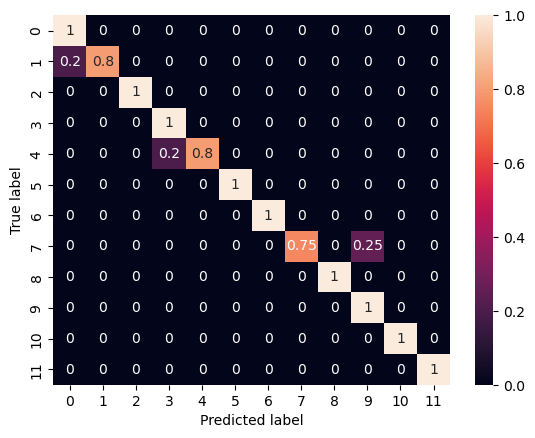

F1 score of the model with combined L1 and PCA features: 0.9191358024691358


In [53]:
# Create a confusion matrix to visualize the performance of the classification model.
confmat = confusion_matrix(y_test, y_pred_combined, normalize="true")

# Plot the confusion matrix using a heatmap for better visualization.
fig, ax = plt.subplots()
sns.heatmap(confmat, annot=True, ax=ax)
ax.set_ylabel("True label")
ax.set_xlabel("Predicted label")
plt.show()

# Calculate the F1 score of the model with combined L1 and PCA features
f1_combined = f1_score(y_test, y_pred_combined, average='weighted')
print(f"F1 score of the model with combined L1 and PCA features: {f1_combined}")

**Question:**

Evaluate the performance using the same metric as point 5. Is there an improvement in the performance?

**Answer:**

There is a little improvement in the performance, as we go from a F1 score of the model with 30 best features of 0.8798 to a F1 score of the improved model with combined L1 regularization and PCA 0.9191.

# Part 2: Generalization across subjects